Ayse Bilgin - 2019203159, Damla Kayikci - 2020400228, Kerem Yavuz - 2020300303

# Setup

In [41]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

df1 = pd.read_csv("gdp_data.csv", sep=";")
df1.rename(columns={"income":"gdp", "capital":"K", "labor":"L"}, inplace=True)
df1['logL'] = np.log(df1['L'])
df1['logK'] = np.log(df1['K'])


# Q1

## a.

In [42]:
# reg
X = df1[['logL', 'logK']]
X = sm.add_constant(X)
y = df1['gdp']
model_a = sm.OLS(y, X).fit()


## b.

      gdp     fitted_gdp     residuals
0  114043   96558.726865  17484.273135
1  120410  110172.106088  10237.893912
2  129187  122783.318055   6403.681945
3  134705  133126.590949   1578.409051
4  139960  142942.828737  -2982.828737
Estimated Parameters:
const   -2.518132e+06
logL     2.248708e+05
logK    -1.208071e+04
dtype: float64

Model Summary:
                            OLS Regression Results                            
Dep. Variable:                    gdp   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     971.4
Date:                Thu, 14 Nov 2024   Prob (F-statistic):           2.99e-18
Time:                        22:46:45   Log-Likelihood:                -206.83
No. Observations:                  20   AIC:                             419.7
Df Residuals:                      17   BIC:                             422.6
Df Model:      

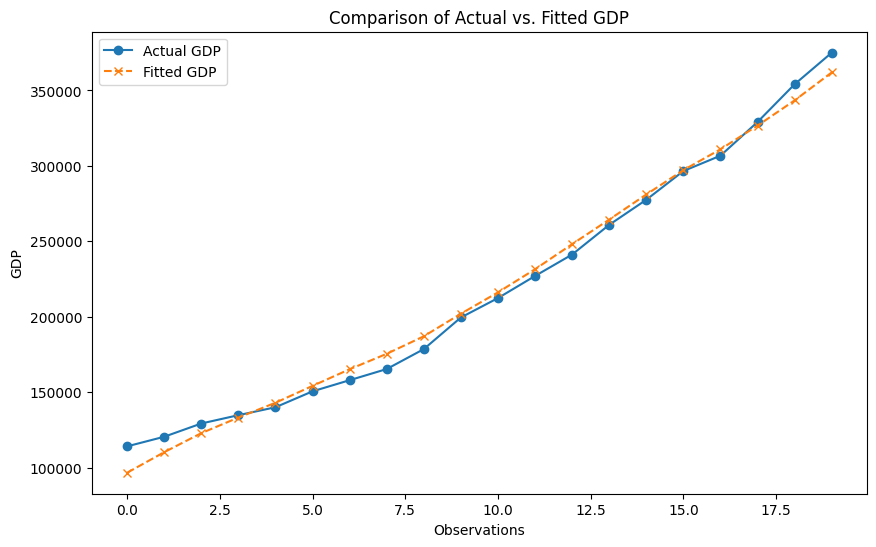

In [43]:
# reg
df_b = df1.copy()

df_b['fitted_gdp'] = model_a.fittedvalues
df_b['residuals'] = model_a.resid
print(df_b[['gdp', 'fitted_gdp', 'residuals']].head())

#plotting
print("Estimated Parameters:")
print(model_a.params)
print("\nModel Summary:")
print(model_a.summary())

plt.figure(figsize=(10, 6))
plt.plot(df_b['gdp'], label='Actual GDP', marker='o')
plt.plot(df_b['fitted_gdp'], label='Fitted GDP', linestyle='--', marker='x')
plt.legend()
plt.xlabel('Observations')
plt.ylabel('GDP')
plt.title('Comparison of Actual vs. Fitted GDP')
plt.show()

## c. - d. - e.

Comparison of True and Estimated Parameters under Different Error Distributions:
       True Parameters  Estimates (Normal)  Estimates (t(5))  \
const    -2.518132e+06       -2.518153e+06     -2.518107e+06   
logL      2.248708e+05        2.248673e+05      2.248709e+05   
logK     -1.208071e+04       -1.207363e+04     -1.208339e+04   

       Estimates (t(10))  Estimates (t(20))  Estimates (t(25))  \
const      -2.518143e+06      -2.518121e+06      -2.518136e+06   
logL        2.248662e+05       2.248711e+05       2.248659e+05   
logK       -1.207319e+04      -1.208227e+04      -1.207362e+04   

       Estimates (t(100))  
const       -2.518105e+06  
logL         2.248741e+05  
logK        -1.208800e+04  


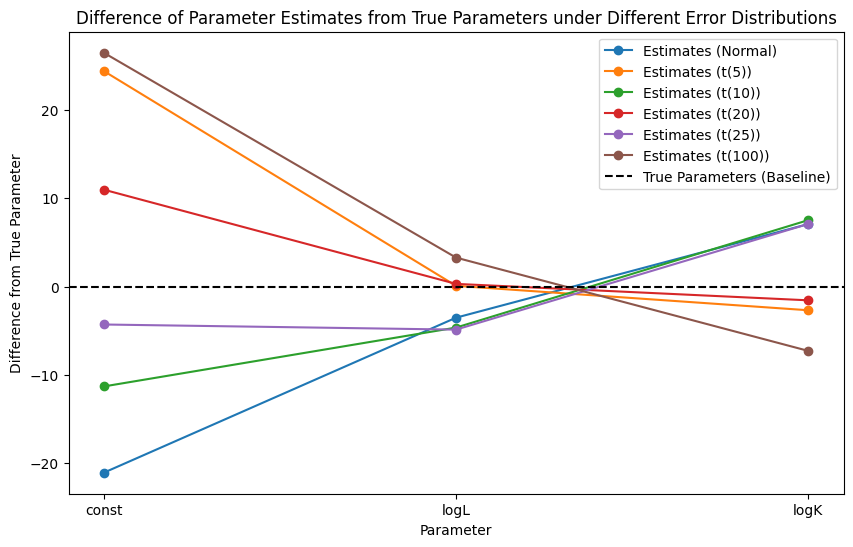

In [44]:
true_params = model_a.params
parameter_comparison = pd.DataFrame(index=true_params.index)
parameter_comparison['True Parameters'] = true_params

# dists
error_distributions = {
    'Normal': np.random.normal(0, 1, len(df1)),
    't(5)': np.random.standard_t(df=5, size=len(df1)),
    't(10)': np.random.standard_t(df=10, size=len(df1)),
    't(20)': np.random.standard_t(df=20, size=len(df1)),
    't(25)': np.random.standard_t(df=25, size=len(df1)),
    't(100)': np.random.standard_t(df=100, size=len(df1)),
}

# reg for each dist
for error_name, error_values in error_distributions.items():
    df_sim = df1.copy()
    df_sim['simulated_gdp'] = model_a.predict() + error_values

    X_sim = df_sim[['logL', 'logK']]
    X_sim = sm.add_constant(X_sim)
    y_sim = df_sim['simulated_gdp']
    model_sim = sm.OLS(y_sim, X_sim).fit()

    parameter_comparison[f'Estimates ({error_name})'] = model_sim.params

print("Comparison of True and Estimated Parameters under Different Error Distributions:")
print(parameter_comparison)

# calculate differences from true parameters for each estimate
parameter_diff = parameter_comparison.subtract(parameter_comparison['True Parameters'], axis=0)

# plotting
plt.figure(figsize=(10, 6))
for col in parameter_diff.columns[1:]:
    plt.plot(parameter_diff.index, parameter_diff[col], marker='o', label=col)
plt.axhline(0, color='black', linestyle='--', label='True Parameters (Baseline)')
plt.xlabel("Parameter")
plt.ylabel("Difference from True Parameter")
plt.title("Difference of Parameter Estimates from True Parameters under Different Error Distributions")
plt.legend()
plt.show()


## f. - g.

In [55]:
true_params = model_a.params
param_df = pd.DataFrame(index=true_params.index)

# f
for error_name, error_values in error_distributions.items():
    df_sim = df1.copy()
    df_sim['simulated_gdp'] = model_a.predict() + error_values

    X_sim = df_sim[['logL', 'logK']]
    X_sim = sm.add_constant(X_sim)
    y_sim = df_sim['simulated_gdp']
    model_sim = sm.OLS(y_sim, X_sim).fit()

    sigma_squared_sim = model_sim.mse_resid
    XTX_inv_sim = np.linalg.inv(np.dot(X_sim.T, X_sim))
    var_cov_matrix_sim = sigma_squared_sim * XTX_inv_sim
    standard_errors_sim = np.sqrt(np.diag(var_cov_matrix_sim))

    param_df[error_name] = standard_errors_sim

# g
num_trials = 1000
monte_carlo_se = {error_name: [] for error_name in error_distributions.keys()}

for trial in range(num_trials):
    for error_name, error_values in error_distributions.items():
        if error_name == 'Normal':
            random_errors = np.random.normal(0, 1, len(df1))
        else:
            df = int(error_name.split('(')[1].split(')')[0])  # Extract degrees of freedom
            random_errors = np.random.standard_t(df=df, size=len(df1))

        df_sim = df1.copy()
        df_sim['simulated_gdp'] = model_a.predict() + random_errors

        X_sim = df_sim[['logL', 'logK']]
        X_sim = sm.add_constant(X_sim)
        y_sim = df_sim['simulated_gdp']
        model_sim = sm.OLS(y_sim, X_sim).fit()

        sigma_squared_sim = model_sim.mse_resid
        XTX_inv_sim = np.linalg.inv(np.dot(X_sim.T, X_sim))
        var_cov_matrix_sim = sigma_squared_sim * XTX_inv_sim
        se_sim = np.sqrt(np.diag(var_cov_matrix_sim))

        monte_carlo_se[error_name].append(se_sim)

mc_avg_se = {error_name: np.mean(monte_carlo_se[error_name], axis=0) for error_name in monte_carlo_se.keys()}
mc_df = pd.DataFrame(mc_avg_se, index=model_a.params.index).add_prefix('MC Avg SE (')
mc_df.columns = [f'MC ({col})' for col in param_df.columns]

#plotting
print("\nParametric Standard Errors:")
print(param_df)
print("Monte Carlo Average Standard Errors:")
print(mc_df)




Parametric Standard Errors:
          Normal       t(5)      t(10)      t(20)      t(25)     t(100)
const  23.768200  44.600987  25.566596  25.756957  28.230289  22.411437
logL    3.655891   6.860274   3.932510   3.961791   4.342225   3.447202
logK    7.282067  13.664786   7.833057   7.891379   8.649155   6.866384
Monte Carlo Average Standard Errors:
       MC (Normal)  MC (t(5))  MC (t(10))  MC (t(20))  MC (t(25))  MC (t(100))
const    21.415759  26.575750   23.840600   22.448989   22.418369    21.603162
logL      3.294052   4.087733    3.667027    3.452978    3.448268     3.322877
logK      6.561329   8.142240    7.304249    6.877889    6.868507     6.618746


## h.

In [56]:
confidence_levels = [0.05, 0.01]
ci_dict = {}


for error_name, error_values in error_distributions.items():
    df_sim = df1.copy()
    df_sim['simulated_gdp'] = model_a.predict() + error_values

    X_sim = df_sim[['logL', 'logK']]
    X_sim = sm.add_constant(X_sim)
    y_sim = df_sim['simulated_gdp']
    model_sim = sm.OLS(y_sim, X_sim).fit()

    params = model_sim.params[['logL', 'logK']]
    standard_errors = model_sim.bse[['logL', 'logK']]

    ci_dict[error_name] = {}
    for alpha in confidence_levels:
        z_score = sp.stats.norm.ppf(1 - alpha / 2)  # Z-score for the two-tailed test
        ci_lower = params - z_score * standard_errors
        ci_upper = params + z_score * standard_errors
        ci_dict[error_name][f'{int((1 - alpha) * 100)}% CI'] = pd.DataFrame({
            'Lower Bound': ci_lower,
            'Upper Bound': ci_upper
        })

for error_name, ci_data in ci_dict.items():
    print(f"\nConfidence Intervals for {error_name} Error Distribution:")
    for level, ci in ci_data.items():
        print(f"{level}:")
        print(ci)



Confidence Intervals for Normal Error Distribution:
95% CI:
        Lower Bound    Upper Bound
logL  224860.118403  224874.449233
logK  -12087.904646  -12059.359468
99% CI:
        Lower Bound    Upper Bound
logL  224857.866866  224876.700770
logK  -12092.389419  -12054.874696

Confidence Intervals for t(5) Error Distribution:
95% CI:
        Lower Bound    Upper Bound
logL  224857.447905  224884.339684
logK  -12110.175460  -12056.610482
99% CI:
        Lower Bound    Upper Bound
logL  224853.222900  224888.564689
logK  -12118.591127  -12048.194814

Confidence Intervals for t(10) Error Distribution:
95% CI:
        Lower Bound    Upper Bound
logL  224858.455848  224873.871006
logK  -12088.537817  -12057.832798
99% CI:
        Lower Bound    Upper Bound
logL  224856.033951  224876.292903
logK  -12093.361925  -12053.008690

Confidence Intervals for t(20) Error Distribution:
95% CI:
        Lower Bound    Upper Bound
logL  224863.347884  224878.877818
logK  -12097.734796  -12066.801158
9

## i.

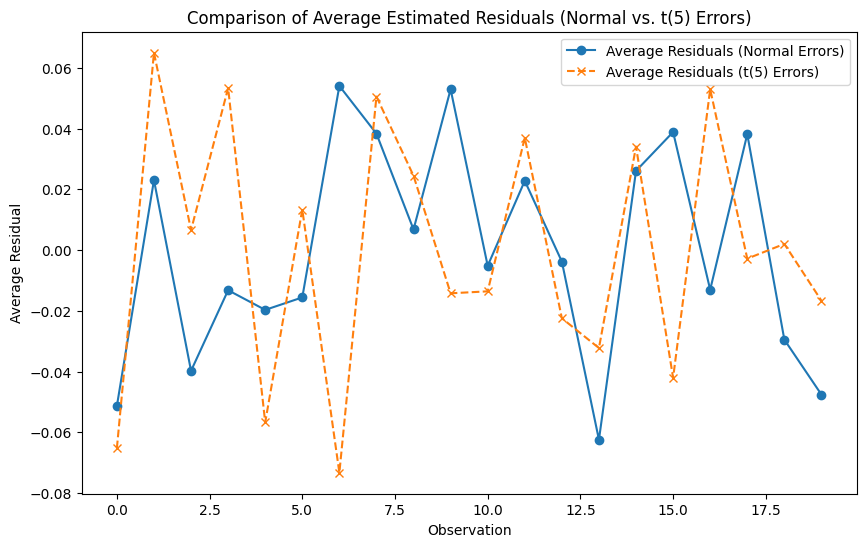

In [57]:
num_trials = 1000
normal_residuals = []
t5_residuals = []

# monte carlo
for trial in range(num_trials):
    #normal
    normal_errors = np.random.normal(0, 1, len(df1))
    df_sim_normal = df1.copy()
    df_sim_normal['simulated_gdp'] = model_a.predict() + normal_errors
    model_normal = sm.OLS(df_sim_normal['simulated_gdp'], X).fit()
    normal_residuals.append(model_normal.resid.values)
    #t(5)
    t5_errors = np.random.standard_t(5, size=len(df1))
    df_sim_t5 = df1.copy()
    df_sim_t5['simulated_gdp'] = model_a.predict() + t5_errors
    model_t5 = sm.OLS(df_sim_t5['simulated_gdp'], X).fit()
    t5_residuals.append(model_t5.resid.values)

avg_normal_residuals = np.mean(normal_residuals, axis=0)
avg_t5_residuals = np.mean(t5_residuals, axis=0)

# plotting
plt.figure(figsize=(10, 6))
plt.plot(avg_normal_residuals, label='Average Residuals (Normal Errors)', marker='o')
plt.plot(avg_t5_residuals, label='Average Residuals (t(5) Errors)', linestyle='--', marker='x')
plt.xlabel('Observation')
plt.ylabel('Average Residual')
plt.title('Comparison of Average Estimated Residuals (Normal vs. t(5) Errors)')
plt.legend()
plt.show()


## j.

In [64]:
num_trials = 1000 #it would have simulated 100.000 in the long-run. but in the long-run, we are all dead.
r_squared_dict = {error_name: [] for error_name in error_distributions.keys()}
adjusted_r_squared_dict = {error_name: [] for error_name in error_distributions.keys()}
# Monte Carlo Simulation with increased error influence
for trial in range(num_trials):
    for error_name, error_values in error_distributions.items():
        # Generate new random errors for each trial, scaled further
        if error_name == 'Normal':
            random_errors = np.random.normal(0, 1, len(df1))
        else:
            df = int(error_name.split('(')[1].split(')')[0])  # Extract degrees of freedom
            random_errors = np.random.standard_t(df=df, size=len(df1))

        df_sim = df1.copy()
        df_sim['simulated_gdp'] = random_errors  # Only errors for testing

        # Define X and y for the simulated model
        X_sim = df_sim[['logL', 'logK']]
        X_sim = sm.add_constant(X_sim)
        y_sim = df_sim['simulated_gdp']

        # Fit the model and calculate R-squared and Adjusted R-squared
        model_sim = sm.OLS(y_sim, X_sim).fit()
        r_squared_dict[error_name].append(model_sim.rsquared)
        adjusted_r_squared_dict[error_name].append(model_sim.rsquared_adj)

# Calculate the new averages
avg_r_squared = {error_name: np.mean(r_values) for error_name, r_values in r_squared_dict.items()}
avg_adjusted_r_squared = {error_name: np.mean(adj_r_values) for error_name, adj_r_values in adjusted_r_squared_dict.items()}

# Convert to DataFrames for easy viewing
avg_r_squared_df = pd.DataFrame(avg_r_squared, index=["Average R-squared"])
avg_adjusted_r_squared_df = pd.DataFrame(avg_adjusted_r_squared, index=["Average Adjusted R-squared"])

# Display updated results
print("Updated Average R-squared for Each Error Distribution (Errors Only):")
print(avg_r_squared_df)
print("\nUpdated Average Adjusted R-squared for Each Error Distribution (Errors Only):")
print(avg_adjusted_r_squared_df)


Updated Average R-squared for Each Error Distribution (Errors Only):
                     Normal      t(5)     t(10)     t(20)     t(25)    t(100)
Average R-squared  0.103147  0.104345  0.102454  0.105869  0.106142  0.099523

Updated Average Adjusted R-squared for Each Error Distribution (Errors Only):
                              Normal      t(5)     t(10)     t(20)     t(25)  \
Average Adjusted R-squared -0.002365 -0.001027 -0.003139  0.000677  0.000983   

                              t(100)  
Average Adjusted R-squared -0.006415  


# Q2

# Q3

# Q4

# Q5

# Q6

# Q7